<a href="https://colab.research.google.com/github/MartaCaste/Master-Big-Data/blob/main/class/Fundamentals/NN_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning/blob/main/class/Fundamentals/NN_Fundamentals.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning/blob/main/class/Fundamentals/NN_Fundamentals.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

tf.random.set_seed(0)

Lo siguiente se ejecuta, son funciones para cargar los datos

In [5]:

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=plt.cm.Spectral)
    
def load_planar_dataset(m, sigma=0.2):
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*sigma # theta
        r = a*np.sin(4*t) + np.random.randn(N)*sigma # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    ## premuting ouput
    p = np.random.permutation(m)
    X = X[p,:]
    Y = Y[p,:]

    return X, Y.ravel()

def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

## Dataset 

We have a binary classification dataset. The target `y` has two possible values, {0,1} and the input vector `x` has two dimensions.

In [6]:
N = 5000
X, y = load_planar_dataset(N, 0.2)

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data. 

Tenemos un problema de clasificación binario. Es un problema complejo, porque una regresión logística que será una recta, nunca aprendera a separar nuestras clases, tnemos que crear un modelo complejo.

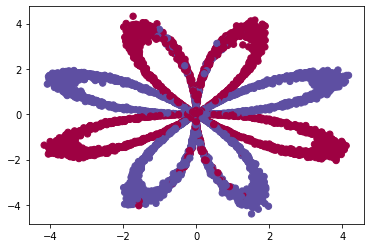

In [7]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [8]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.2,
)

In [9]:
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [10]:
## X first example
X[0,:]

array([-0.89348444, -0.05122573])

Los valores de las x son las coordenadas y los de las y son ceros y unos dependiendo de la clase

In [11]:
## Y firsts examples
y[:8]

array([0, 1, 1, 1, 1, 0, 0, 1], dtype=uint8)

## First NN in Keras

### Logistic regression

Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class. We can specify the number of neurons as the first argument, and specify the activation function using the activation argument.

```python
tf.keras.layers.Dense(
    units, activation=None
)

```

- **units**: Number of neurons in the layer.
- **activation**: Activation function to use, default function is `linear`, you can also use `sigmoid` for sigmoid activation or [other alternatives](https://www.tensorflow.org/api_docs/python/tf/keras/activations) 

For defining the input layer you can use `keras.Input(shape=(input_dimension,))` or define your input dimension in the first hidden layer.

```python
layers.Dense(4, activation="sigmoid", input_shape=(input_dimension,))

```

Build a network without hidden layer

A continuación la diseñamos

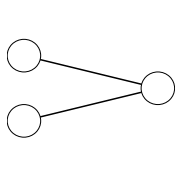

In [12]:
draw_neural_net(.1, .9, .1, .9, [2, 1])

Primero se crea el modelo vacio y luego se le van añadiendo las capas. En este caso solo tenemos una capa de salida con una neurona.

In [12]:
model = keras.Sequential()
# The dimension of the input is 2 (planar data)
# we have only one output layer with 1 neuron
model.add(keras.layers.Dense(1, input_shape=(2, ), activation='sigmoid'))

In [13]:
model.summary()
#vemos un resumen. 2 pesos y el b, es decir, tres parametros

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


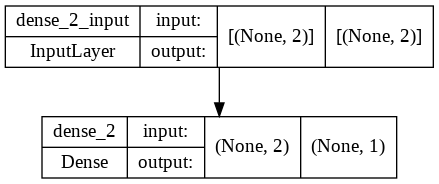

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

#### Compile
Now we need to specify the loss function, the metrics and the optimizer. It is done using compile function in Keras.

Una vez declarado el modelo se tiene que compilar. Binary_crossentropy es porque es binario. Mas adelante veremos que es cada cosa. 

In [15]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Training model
This is similar to a sklearn model.

In [16]:
model.fit(X_train, y_train, epochs=10,
          validation_split=0.2, batch_size=32)

Epoch 1/10
100/100 [==============================] - 1s 4ms/step - loss: 1.2735 - accuracy: 0.3294 - val_loss: 1.2020 - val_accuracy: 0.3388
Epoch 2/10
100/100 [==============================] - 0s 3ms/step - loss: 1.1685 - accuracy: 0.3369 - val_loss: 1.1037 - val_accuracy: 0.3462
Epoch 3/10
100/100 [==============================] - 0s 3ms/step - loss: 1.0713 - accuracy: 0.3459 - val_loss: 1.0153 - val_accuracy: 0.3575
Epoch 4/10
100/100 [==============================] - 0s 3ms/step - loss: 0.9837 - accuracy: 0.3556 - val_loss: 0.9355 - val_accuracy: 0.3725
Epoch 5/10
100/100 [==============================] - 0s 3ms/step - loss: 0.9071 - accuracy: 0.3647 - val_loss: 0.8673 - val_accuracy: 0.3887
Epoch 6/10
100/100 [==============================] - 0s 3ms/step - loss: 0.8424 - accuracy: 0.3816 - val_loss: 0.8111 - val_accuracy: 0.4087
Epoch 7/10
100/100 [==============================] - 0s 3ms/step - loss: 0.7901 - accuracy: 0.4097 - val_loss: 0.7672 - val_accuracy: 0.4325
Epoch 

El entrenamiento nos va mostrando una descripcion de que va pasando en cada época, que es cada vez que recorre el dataset entero, nos pone su funcion de perdida y el accuracy, tanto del train como del validation, el que nos importa es el validation

#### Making predictions

In [17]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.6925243735313416
Test Accuracy: 0.574999988079071


In [18]:
y_pred = model.predict(X_test)
y_pred[:3], y_test[:3]

(array([[0.47558922],
        [0.52599925],
        [0.5946407 ]], dtype=float32), array([0, 0, 1], dtype=uint8))

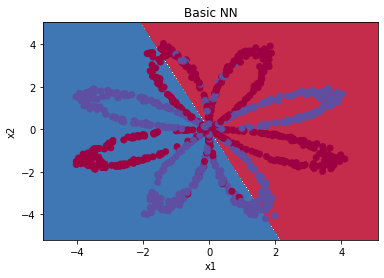

In [19]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("Basic NN");

Necesitamos un modelo mas complejo. Para ello añadimos una capa oculta a la red neuronal 

### One hidden layer NN

- One **input with 2 features (input_shape)**
- **One hidden dense layer**,  with **3 neurons** and implemented with  **sigmoid activating function**
- **One Output** (sigmoid output activation function)

We can create layers incrementally with the method `add()`:

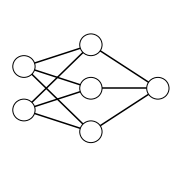

In [20]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 1])
#Vamos a tratar de diseñar esta red neuronal con una capa oculta de 3 neuronas

In [21]:
model = keras.Sequential()

## hidden layer with 3 neurons and sigmoid activation
## The first layer need to have the input_shape
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

## model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 3)                 9         
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


3 pesos por 2 neuronas + 3 b=9
3 pesos por 1 neurona + 1 b=4
Total 13

You can also define the model with a list of layers
```python
model = keras.Sequential([
    keras.Input(shape=(2, )),
    layers.Dense(3, activation='sigmoid', name='layer1'),
    layers.Dense(1, activation='sigmoid', name='layer3')
])
````

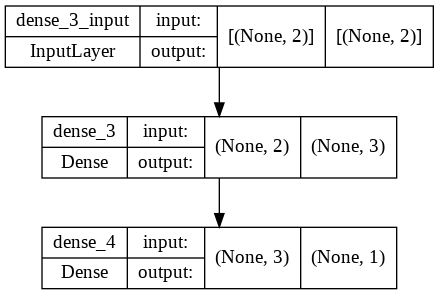

In [22]:
plot_model(model, show_shapes=True)

In [23]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 7ms/step - loss: 0.8742 - accuracy: 0.4981 - val_loss: 0.8311 - val_accuracy: 0.4950
Epoch 2/25
100/100 [==============================] - 1s 8ms/step - loss: 0.8014 - accuracy: 0.5181 - val_loss: 0.7704 - val_accuracy: 0.5537
Epoch 3/25
100/100 [==============================] - 1s 6ms/step - loss: 0.7487 - accuracy: 0.5494 - val_loss: 0.7291 - val_accuracy: 0.5163
Epoch 4/25
100/100 [==============================] - 1s 6ms/step - loss: 0.7141 - accuracy: 0.5044 - val_loss: 0.7025 - val_accuracy: 0.4938
Epoch 5/25
100/100 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5491 - val_loss: 0.6864 - val_accuracy: 0.5700
Epoch 6/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6795 - accuracy: 0.6047 - val_loss: 0.6765 - val_accuracy: 0.6313
Epoch 7/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.6600 - val_loss: 0.6696 - val_accuracy: 0.6700
Epoch 

In [24]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.611269474029541
Test Accuracy: 0.6470000147819519


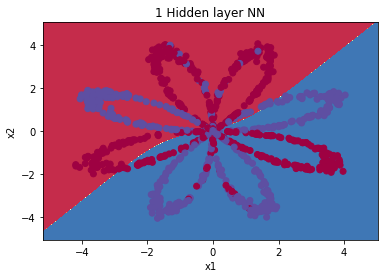

In [46]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN");

### Question 1:
####  What happens if we change the activation function of the first hidden  layer to `'linear'`? 

Si ponemos una capa lineal, es como si no pusieramos nada. Al final seria como una regresión logística. Veamos que ocurre

In [25]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation='linear'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [26]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 4ms/step - loss: 1.0205 - accuracy: 0.6375 - val_loss: 0.9435 - val_accuracy: 0.6212
Epoch 2/25
100/100 [==============================] - 0s 3ms/step - loss: 0.8308 - accuracy: 0.6266 - val_loss: 0.7880 - val_accuracy: 0.6087
Epoch 3/25
100/100 [==============================] - 0s 2ms/step - loss: 0.7270 - accuracy: 0.6041 - val_loss: 0.7128 - val_accuracy: 0.5838
Epoch 4/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6811 - accuracy: 0.5647 - val_loss: 0.6815 - val_accuracy: 0.5275
Epoch 5/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6651 - accuracy: 0.5172 - val_loss: 0.6715 - val_accuracy: 0.4825
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.4891 - val_loss: 0.6683 - val_accuracy: 0.4387
Epoch 7/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6597 - accuracy: 0.4619 - val_loss: 0.6678 - val_accuracy: 0.4500
Epoch 

Test Loss: 0.661709725856781
Test Accuracy: 0.4659999907016754


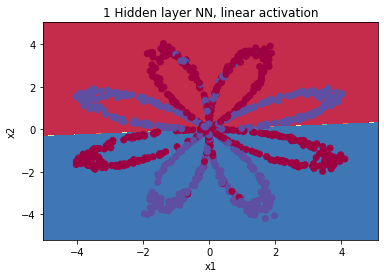

In [27]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

Observamos que la frontera de decision es una recta. Con lo cual no nos sirve este modelo. 

### Question 2:
####  What happens if we add more neurons to the first hidden layer ? 

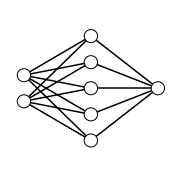

In [28]:
draw_neural_net(.1, .9, .1, .9, [2, 5, 1])

In [32]:
model = keras.Sequential()

## The first layer need to have the input_shape
## set the number of neurons
model.add(layers.Dense(5, input_shape=(2,), activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [33]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 6ms/step - loss: 0.7091 - accuracy: 0.5119 - val_loss: 0.6915 - val_accuracy: 0.5275
Epoch 2/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6786 - accuracy: 0.5656 - val_loss: 0.6739 - val_accuracy: 0.5525
Epoch 3/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6656 - accuracy: 0.5278 - val_loss: 0.6656 - val_accuracy: 0.5050
Epoch 4/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6577 - accuracy: 0.5491 - val_loss: 0.6593 - val_accuracy: 0.5875
Epoch 5/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6515 - accuracy: 0.5956 - val_loss: 0.6540 - val_accuracy: 0.6050
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6122 - val_loss: 0.6489 - val_accuracy: 0.6237
Epoch 7/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6408 - accuracy: 0.6228 - val_loss: 0.6440 - val_accuracy: 0.6338
Epoch 

Test Loss: 0.540229856967926
Test Accuracy: 0.7089999914169312


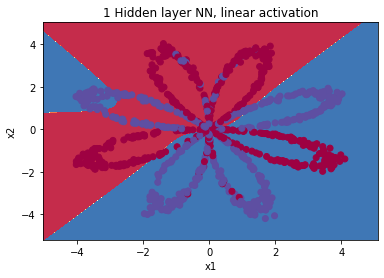

In [34]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

Vemos que el modelo mejora y ya aprende mas cosas.

### Question 3:
####  What happens if we add one more hidden layer ? 

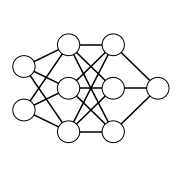

In [35]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 3, 1])

In [41]:
model = keras.Sequential()
# First hidden layer (need to innclude input_shape)
## Set the number of neurons
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))

# second hidden layer
## Complete the code
model.add(layers.Dense(3, activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [42]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 4ms/step - loss: 0.7161 - accuracy: 0.4981 - val_loss: 0.7050 - val_accuracy: 0.4950
Epoch 2/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6985 - accuracy: 0.4981 - val_loss: 0.6946 - val_accuracy: 0.4950
Epoch 3/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5091 - val_loss: 0.6903 - val_accuracy: 0.5362
Epoch 4/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6877 - accuracy: 0.4919 - val_loss: 0.6869 - val_accuracy: 0.4450
Epoch 5/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6843 - accuracy: 0.5263 - val_loss: 0.6837 - val_accuracy: 0.5638
Epoch 6/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6806 - accuracy: 0.5838 - val_loss: 0.6801 - val_accuracy: 0.6087
Epoch 7/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6768 - accuracy: 0.6175 - val_loss: 0.6762 - val_accuracy: 0.6375
Epoch 

Test Loss: 0.6030990481376648
Test Accuracy: 0.6600000262260437


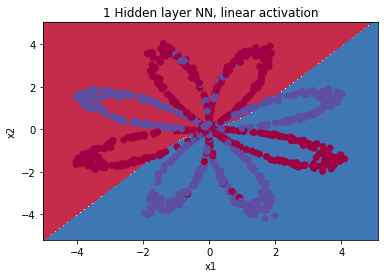

In [43]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

el modelo mejora un poco

####  Use  the [hyperbolic tangent](https://mathworld.wolfram.com/HyperbolicTangent.html) activation `'tanh'` with the first simple model and compare the results with the sigmoid activation

In [44]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation='tanh'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [45]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 4ms/step - loss: 0.7655 - accuracy: 0.3150 - val_loss: 0.7313 - val_accuracy: 0.3837
Epoch 2/25
100/100 [==============================] - 0s 2ms/step - loss: 0.7108 - accuracy: 0.4462 - val_loss: 0.6906 - val_accuracy: 0.4800
Epoch 3/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6754 - accuracy: 0.5019 - val_loss: 0.6656 - val_accuracy: 0.4675
Epoch 4/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6528 - accuracy: 0.5644 - val_loss: 0.6484 - val_accuracy: 0.6000
Epoch 5/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6376 - accuracy: 0.6031 - val_loss: 0.6366 - val_accuracy: 0.6162
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6125 - val_loss: 0.6274 - val_accuracy: 0.6237
Epoch 7/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6172 - accuracy: 0.6156 - val_loss: 0.6195 - val_accuracy: 0.6212
Epoch 

Test Loss: 0.5664358735084534
Test Accuracy: 0.6179999709129333


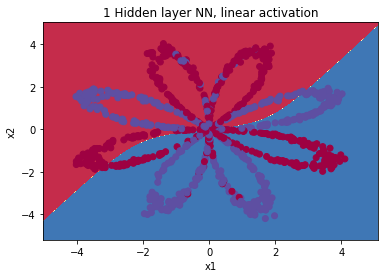

In [46]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

## Practice I

Repeat the process with a different dataset.

In [47]:
N = 5000
X, y = sklearn.datasets.make_moons(n_samples=N, noise=.18)

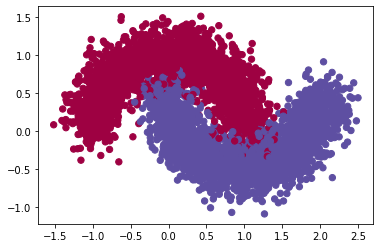

In [48]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [49]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


### Define your model

In [53]:
model = keras.Sequential()
## The first layer need to have the input_shape
model.add(layers.Dense(8, input_shape=(2,), activation='tanh'))

## Second Layer, don't use input_shape
model.add(layers.Dense(8, activation='tanh'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [54]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

Epoch 1/35
47/47 [==============================] - 1s 5ms/step - loss: 0.9572 - accuracy: 0.1907 - val_loss: 0.8446 - val_accuracy: 0.2360
Epoch 2/35
47/47 [==============================] - 0s 3ms/step - loss: 0.7645 - accuracy: 0.3273 - val_loss: 0.6856 - val_accuracy: 0.4600
Epoch 3/35
47/47 [==============================] - 0s 3ms/step - loss: 0.6249 - accuracy: 0.6263 - val_loss: 0.5653 - val_accuracy: 0.7613
Epoch 4/35
47/47 [==============================] - 0s 3ms/step - loss: 0.5215 - accuracy: 0.7957 - val_loss: 0.4788 - val_accuracy: 0.8133
Epoch 5/35
47/47 [==============================] - 0s 3ms/step - loss: 0.4483 - accuracy: 0.8260 - val_loss: 0.4184 - val_accuracy: 0.8440
Epoch 6/35
47/47 [==============================] - 0s 3ms/step - loss: 0.3978 - accuracy: 0.8433 - val_loss: 0.3762 - val_accuracy: 0.8573
Epoch 7/35
47/47 [==============================] - 0s 3ms/step - loss: 0.3626 - accuracy: 0.8533 - val_loss: 0.3475 - val_accuracy: 0.8653
Epoch 8/35
47/47 [==

Test Loss: 0.2964945435523987
Test Accuracy: 0.871999979019165


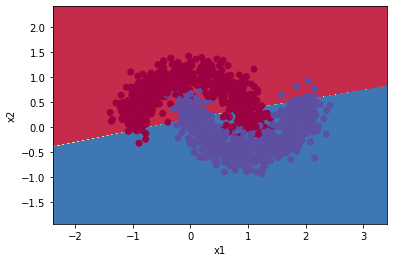

In [55]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

El modelo con sigmoid no esta mal pero podria ir mejor. Si cambiamos en la primera capa y segunda sigmoid por tanh, mejora. 

## Functional API

Hasta ahora hemos visto el diseño de nn con .add que es la API secuencial. Para redes mas complejas se utiliza la API funcional.

The Keras Functional API allows defining the topology of the models as a [acyclic directed graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph) of layers. Next we will build the same model as in the previous section but using the Keras Functional API.

You need to start with an input data entry:
```python    
    inputs = keras.Input(shape=(8,))
```
    
We define the layers that we will include in the network and the relationships between them. It is important to note that each line details the type of layer and its properties (number of neurons, activation function, name ...) and just at the end, in parentheses, the name of the variable in which we have saved the layer from which its output will connect to the input of the layer we are declaring.
Se llama a cada capa declarando la anterior y finalmente se define una salida.
```python
layer_1 = layers.Dense(4, activation='sigmoid',
                       name='layer_1')(inputs)
layer_2 = layers.Dense(4, activation='sigmoid',
                       name='layer_2')(layer_1)
```

The "layer call" `Dense()(inputs)` action is like drawing an arrow from "inputs" to this layer you created. You're "passing" the inputs to the dense layer, and you get `layer_1` as the output.

  

Finally, we define the network outputs:
```python
outputs = layers.Dense(1, name='output_layer')(layer_2)
```

We create the model specifying the inputs and outputs:
```python
model = keras.Model(inputs=inputs, outputs=outputs)
```

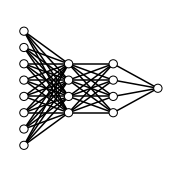

In [56]:
draw_neural_net(.1, .9, .1, .9, [8, 4, 4, 1])

In [57]:
inputs = keras.Input(shape=(8, ), name='input_layer')
l_1 = layers.Dense(4, activation='relu', name='layer_1')(inputs)
l_2 = layers.Dense(4, activation='relu', name='layer_2')(l_1)
outputs = layers.Dense(1, name='output_layer')(l_2)

model = keras.Model(inputs=inputs, outputs=outputs, name='example_model')

model.summary()

Model: "example_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 8)]               0         
                                                                 
 layer_1 (Dense)             (None, 4)                 36        
                                                                 
 layer_2 (Dense)             (None, 4)                 20        
                                                                 
 output_layer (Dense)        (None, 1)                 5         
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


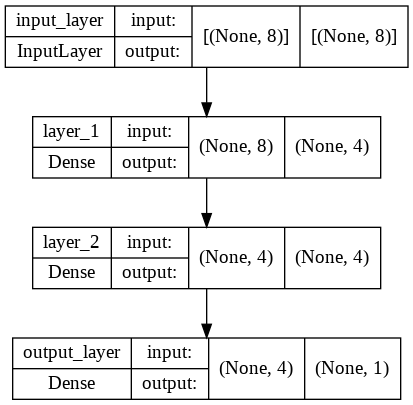

In [58]:
plot_model(model, show_shapes=True)

## Practice II

Repeat the process with a different dataset and the **Functional API**

In [59]:
N = 5000
X, y = sklearn.datasets.make_circles(n_samples=N, factor=.65, noise=.065) # sklearn.datasets.make_moons(n_samples=N, noise=.15)

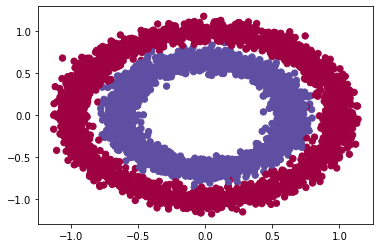

In [60]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [61]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


### Define your model

In [62]:
inputs = keras.Input(shape=(2, ), name='input_layer')
## First hidden layer
l_1 = layers.Dense(8, activation='tanh')(inputs)
l_2=layers.Dense(8, activation='tanh')(l_1)

## output layer
outputs = layers.Dense(1, activation='sigmoid')(l_2)
                       

model = keras.Model(inputs=inputs, outputs=outputs)

In [63]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

Epoch 1/35
47/47 [==============================] - 1s 6ms/step - loss: 0.7105 - accuracy: 0.5037 - val_loss: 0.6918 - val_accuracy: 0.5267
Epoch 2/35
47/47 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5150 - val_loss: 0.6874 - val_accuracy: 0.5453
Epoch 3/35
47/47 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5980 - val_loss: 0.6857 - val_accuracy: 0.6360
Epoch 4/35
47/47 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.6360 - val_loss: 0.6831 - val_accuracy: 0.6427
Epoch 5/35
47/47 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.6787 - val_loss: 0.6794 - val_accuracy: 0.7147
Epoch 6/35
47/47 [==============================] - 0s 3ms/step - loss: 0.6757 - accuracy: 0.6850 - val_loss: 0.6751 - val_accuracy: 0.7147
Epoch 7/35
47/47 [==============================] - 0s 3ms/step - loss: 0.6713 - accuracy: 0.7250 - val_loss: 0.6707 - val_accuracy: 0.6973
Epoch 8/35
47/47 [==

Test Loss: 0.2206467092037201
Test Accuracy: 0.9904000163078308


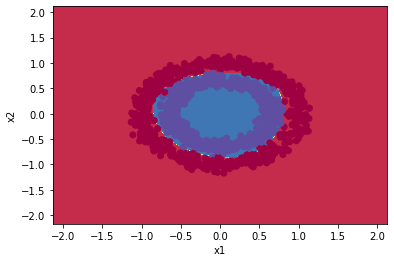

In [64]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)